In [1]:
import pandas as pd

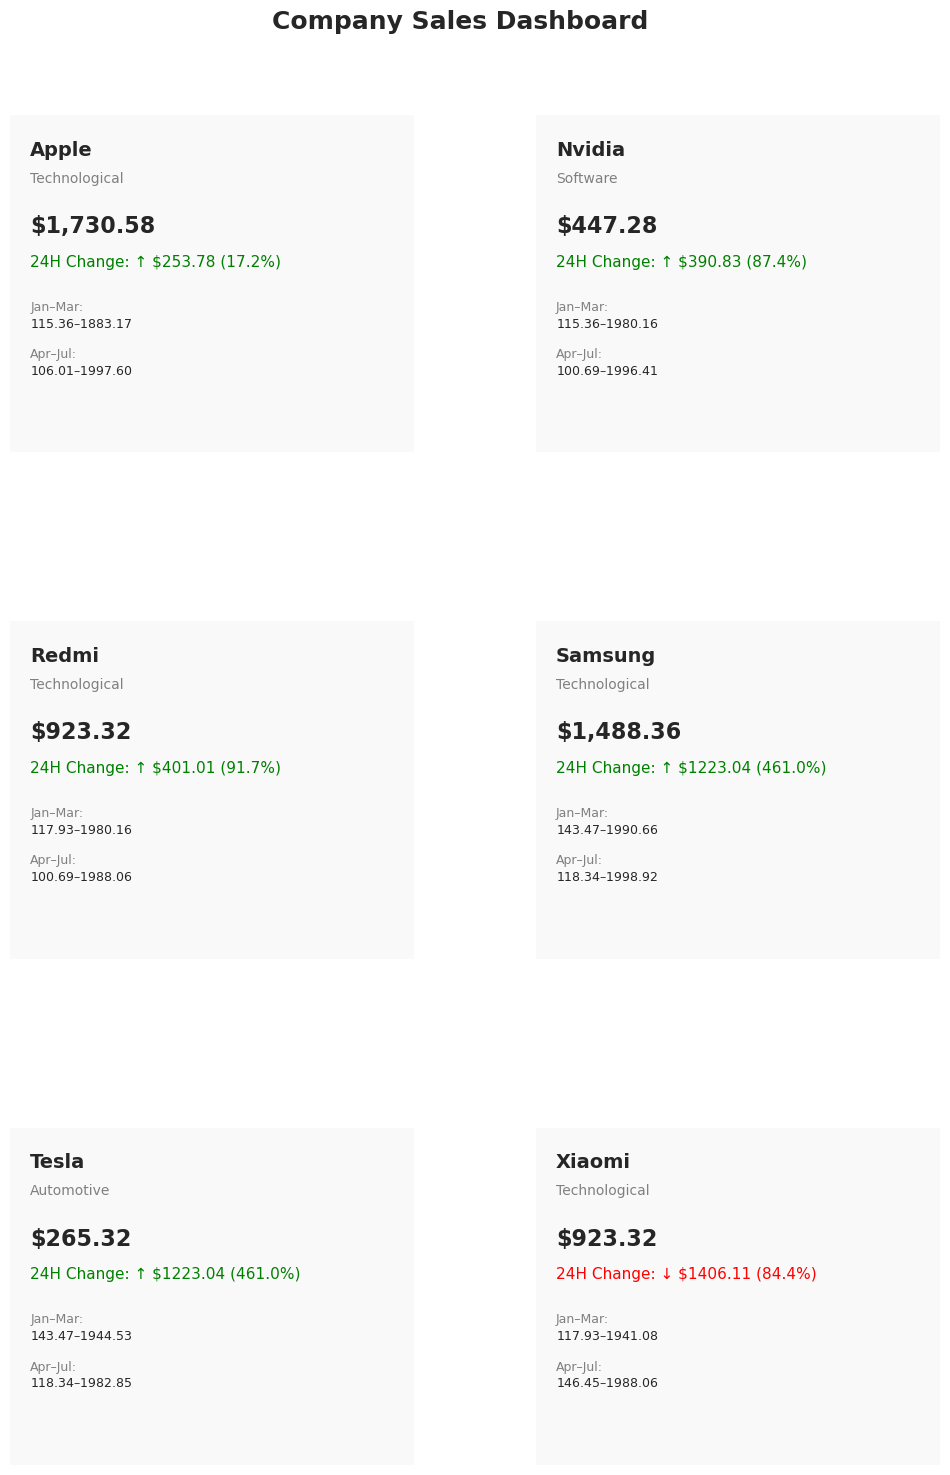

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from math import ceil
import os
from PIL import Image

# --- Load data ---
csv_path = 'CompanySalesData.csv'
xlsx_path = 'day 1.xlsx'

df_csv = pd.read_csv(csv_path)
df_xlsx = pd.read_excel(xlsx_path)

df_xlsx = df_xlsx[['category', 'company_name', 'price', 'date']]
df = pd.concat([df_csv, df_xlsx], ignore_index=True)
df['date'] = pd.to_datetime(df['date'])
df = df.dropna(subset=['company_name', 'price', 'date'])

# --- Latest price ---
latest_prices = df.sort_values('date').groupby('company_name').tail(1).set_index('company_name')

# --- 24H Change ---
def get_24h_change(df_company):
    df_sorted = df_company.sort_values('date')
    if len(df_sorted) >= 2:
        last_two = df_sorted.tail(2)
        change = last_two.iloc[1]['price'] - last_two.iloc[0]['price']
        pct = (change / last_two.iloc[0]['price']) * 100
        return change, pct
    return 0, 0

# --- Load logo image ---
def get_company_logo_image(company_name, folder='logos'):
    for ext in ['.png', '.jpg', '.jpeg']:
        path = os.path.join(folder, f"{company_name}{ext}")
        if os.path.exists(path):
            try:
                return OffsetImage(Image.open(path), zoom=0.2)
            except:
                return None
    return None

# --- Plot single company card ---
def plot_company_card(ax, company, df_company, category):
    df_company = df_company.sort_values('date')
    latest_price = latest_prices.loc[company]['price']
    change, pct_change = get_24h_change(df_company)

    arrow = "↑" if change >= 0 else "↓"
    color = 'green' if change >= 0 else 'red'
    change_str = f"{arrow} ${abs(change):.2f} ({abs(pct_change):.1f}%)"

    jan_data = df_company[df_company['date'].dt.month <= 3]
    jul_data = df_company[df_company['date'].dt.month > 3]

    jan_range = (jan_data['price'].min(), jan_data['price'].max()) if not jan_data.empty else (0, 0)
    jul_range = (jul_data['price'].min(), jul_data['price'].max()) if not jul_data.empty else (0, 0)

    # Text info
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('#f9f9f9')
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.text(0.05, 0.88, company, fontsize=14, fontweight='bold', transform=ax.transAxes)
    ax.text(0.05, 0.8, f"{category}", fontsize=10, color='gray', transform=ax.transAxes)
    ax.text(0.05, 0.65, f"${latest_price:,.2f}", fontsize=16, fontweight='bold', transform=ax.transAxes)
    ax.text(0.05, 0.55, f"24H Change: {change_str}", fontsize=11, color=color, transform=ax.transAxes)
    ax.text(0.05, 0.42, "Jan–Mar:", fontsize=9, color='gray', transform=ax.transAxes)
    ax.text(0.05, 0.37, f"${jan_range[0]:.2f} – ${jan_range[1]:.2f}", fontsize=9, transform=ax.transAxes)
    ax.text(0.05, 0.28, "Apr–Jul:", fontsize=9, color='gray', transform=ax.transAxes)
    ax.text(0.05, 0.23, f"${jul_range[0]:.2f} – ${jul_range[1]:.2f}", fontsize=9, transform=ax.transAxes)

    # Add company logo
    imagebox = get_company_logo_image(company)
    if imagebox:
        ab = AnnotationBbox(imagebox, (0.85, 0.75), frameon=False, xycoords='axes fraction')
        ax.add_artist(ab)

# --- Plot all ---
sns.set(style='whitegrid')

companies = sorted(df['company_name'].unique())
cols = 2
rows = ceil(len(companies) / cols)

fig = plt.figure(figsize=(12, rows * 5))
gs = gridspec.GridSpec(rows, cols, hspace=0.5, wspace=0.3)

for i, company in enumerate(companies):
    ax = plt.subplot(gs[i])
    df_company = df[df['company_name'] == company]
    category = df_company['category'].iloc[-1] if 'category' in df_company.columns else 'Unknown'
    plot_company_card(ax, company, df_company, category)

plt.suptitle("Company Sales Dashboard", fontsize=18, fontweight='bold', y=1.02)
plt.subplots_adjust(top=0.95, bottom=0.05, hspace=0.4, wspace=0.3)
plt.show()
